## Setup

In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from harp_resources import process, utils
from sleap import load_and_process as lp

In [2]:
data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_220824/2024-08-22T13-13-15_B3M6')
photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_220824/photometry/B3M6_MMclosed&Regular_day1/2024_08_22-15_16_40')

## Videography and SLEAP

In [3]:
# lp.create_flipped_videos(data_path, what_to_flip='VideoData1')

In [4]:
VideoData1, VideoData2 = lp.load_videography_data(data_path)

INFO:
load_and_process.load_videography_data() function expects the following format of SLEAP outputs:
"VideoData1_1904-01-01T00-00-00.sleap.csv"
"VideoData1_1904-01-01T23-59-59.sleap.csv"
"..."
Please make sure to rename SLEAP files if they are not already following this convention.


RESULTS:
Outputs of SLEAP found in VideoData1: False
Outputs of SLEAP found in VideoData2: True
Found .csv VideoData logs timestamped at:
- 1904-01-05T02:00:00.000000000
Reading dataframes finished.
VideoData2 SLEAP output: 114387 frames registered, but 114202 rows found inside file. Filling with empty rows.


In [5]:
# SLEAP processing

VideoData2 = VideoData2.interpolate()

columns_of_interest = ['left.x','left.y','center.x','center.y','right.x','right.y','p1.x','p1.y','p2.x','p2.y','p3.x','p3.y','p4.x','p4.y','p5.x','p5.y','p6.x','p6.y','p7.x','p7.y','p8.x','p8.y']
coordinates_dict = lp.get_coordinates_dict(VideoData2, columns_of_interest)

theta = lp.find_horizontal_axis_angle(VideoData2, 'left', 'center')
center_point = lp.get_left_right_center_point(coordinates_dict)

columns_of_interest = ['left', 'right', 'center', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
remformatted_coordinates_dict = lp.get_reformatted_coordinates_dict(coordinates_dict, columns_of_interest)
centered_coordinates_dict = lp.get_centered_coordinates_dict(remformatted_coordinates_dict, center_point)
rotated_coordinates_dict = lp.get_rotated_coordinates_dict(centered_coordinates_dict, theta)

columns_of_interest = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
ellipse_parameters_data, ellipse_center_points_data = lp.get_fitted_ellipse_parameters(rotated_coordinates_dict, columns_of_interest)

SleapData = process.convert_arrays_to_dataframe(['Seconds', 'Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'], [VideoData2['Seconds'].values, ellipse_parameters_data[:,0], ellipse_parameters_data[:,1], ellipse_parameters_data[:,2], ellipse_center_points_data[:,0], ellipse_center_points_data[:,1]])

## Loading and Synchronisation

In [6]:
conversions = process.calculate_conversions_second_approach(data_path, photometry_path, verbose=False)

OnixAnalogClock loaded in 0.80 seconds.
Calculation of conversions finished in 11.96 seconds.


In [7]:
streams = utils.load_registers(data_path)

# Photometry = utils.read_fluorescence(photometry_path)
Photometry = pd.read_csv('/home/ikharitonov/Downloads/preprocessed_grab2.csv')
Photometry['TimeStamp'] = Photometry['TimeStamp'] * 1000
Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])

streams = process.reformat_and_add_many_streams(streams, Photometry, 'Photometry', ['470_dfF'], index_column_name='HARP Timestamps')
streams = process.reformat_and_add_many_streams(streams, SleapData, 'Eye Movements', ['Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'])

_ = process.get_timepoint_info(streams, print_all=True)
resampled_streams = process.pad_and_resample(streams, resampling_period='0.1ms', method='linear')
_ = process.get_timepoint_info(resampled_streams, print_all=True)

Dataset 2024-08-22T13-13-15_B3M6 contains following registers:
H1: [33, 32, 46]
H2: [39, 42]
Registers loaded in 1.46 seconds.
Global first timestamp: 1904-01-05 02:08:50.632352
Global last timestamp: 1904-01-05 02:40:44.168925404
Global length: 0 days 00:31:53.536573404

H1
Cam1Event(33): 
	first  1904-01-05 02:08:51.182336 
	last   1904-01-05 02:40:37.417280 
	length 0 days 00:31:46.234944 
	mean difference between timestamps 0 days 00:00:00.016666097
Cam0Event(32): 
	first  1904-01-05 02:08:51.182304 
	last   1904-01-05 02:40:37.417280 
	length 0 days 00:31:46.234976 
	mean difference between timestamps 0 days 00:00:00.016666098
OpticalTrackingRead0X(46): 
	first  1904-01-05 02:08:51.190240 
	last   1904-01-05 02:40:37.430240 
	length 0 days 00:31:46.240000 
	mean difference between timestamps 0 days 00:00:00.010000
OpticalTrackingRead0Y(46): 
	first  1904-01-05 02:08:51.190240 
	last   1904-01-05 02:40:37.430240 
	length 0 days 00:31:46.240000 
	mean difference between timestamps 0

OnixAnalogClock loaded in 0.84 seconds.
OnixAnalogData loaded in 34.63 seconds.
Selection of photodiode data finished in 0.75 seconds.


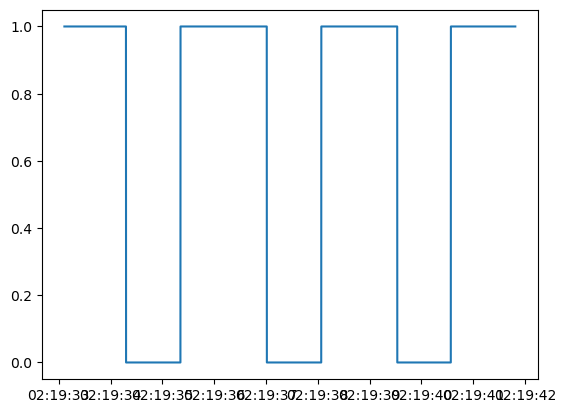

In [8]:
# Loading data
OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
OnixAnalogData = utils.read_OnixAnalogData(data_path, binarise=True)
ExperimentEvents = utils.read_ExperimentEvents(data_path)

# Selecting desired HARP times, applying conversion to ONIX time
start_harp_time_of_halt_one = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[0].Seconds
start_harp_time_of_halt_four = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[3].Seconds

# Selecting photodiode times and data within the range, converting back to HARP and plotting
selected_harp_times, selected_photodiode_data = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, start_harp_time_of_halt_one - 1, start_harp_time_of_halt_four, conversions)

plt.plot(selected_harp_times, selected_photodiode_data[:, 0])
plt.show()

## Usage

In [9]:
from scipy import signal

In [10]:
def moving_avarage_smoothing(X,k):
    S = np.zeros(X.shape[0])
    for t in range(X.shape[0]):
        if t < k:
            S[t] = np.mean(X[:t+1])
        else:
            S[t] = np.sum(X[t-k:t])/k
    return S

In [11]:
running = resampled_streams['H1']['OpticalTrackingRead0Y(46)']
# running = moving_avarage_smoothing(running,50)
photometry = resampled_streams['Photometry']['470_dfF']
eye_movements = resampled_streams['Eye Movements']['Ellipse.Center.X']

In [12]:
def running_unit_conversion(running_array):
    resolution = 12000 # counts per inch
    inches_per_count = 1 / resolution
    meters_per_count = 0.0254 * inches_per_count
    dt = 0.01 # for OpticalTrackingRead0Y(46)
    linear_velocity = meters_per_count / dt # meters per second per count
    
    # ball_radius = 0.1 # meters 
    # angular_velocity = linear_velocity / ball_radius # radians per second per count
    # angular_velocity = angular_velocity * (180 / np.pi) # degrees per second per count
    # print(angular_velocity)

    return running_array * linear_velocity

In [13]:
running = running_unit_conversion(running) # meters per second
running *= 100 # centimeters per second

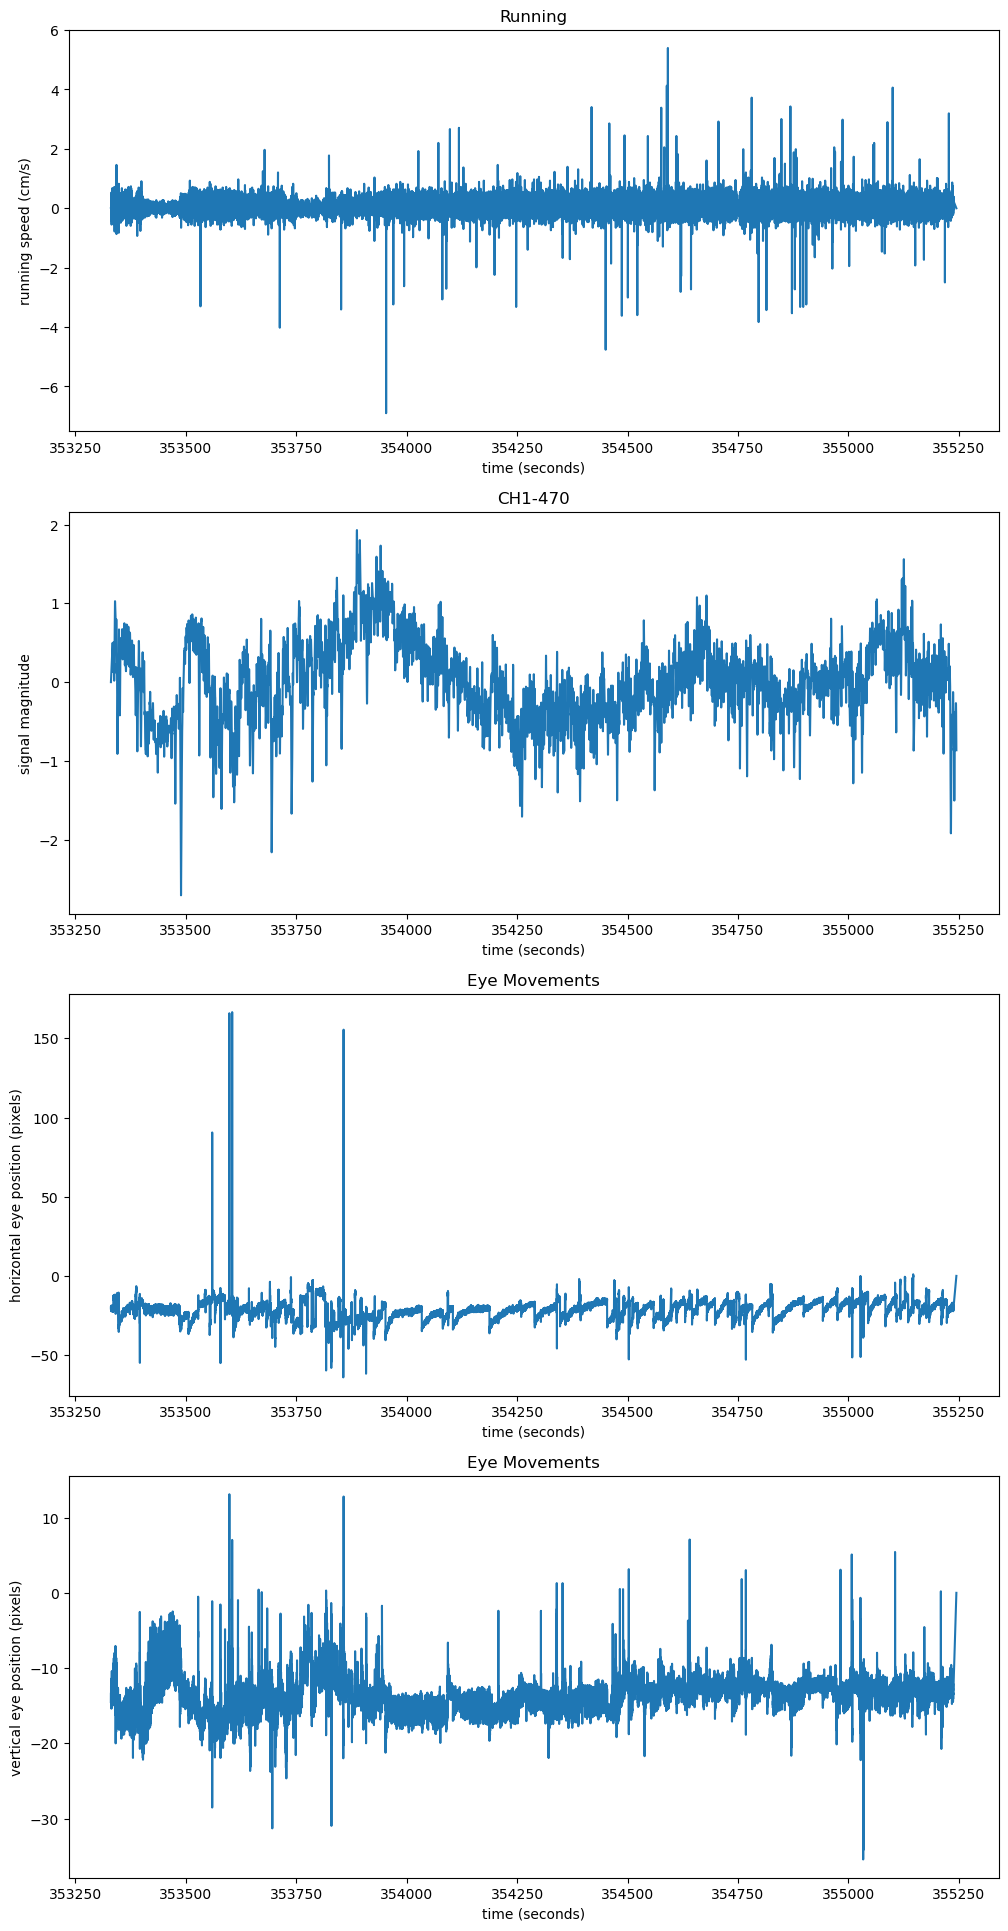

In [14]:
A = None
B = None
# A = 432900
# B = A + 30

# photodiode_x, photodiode_y = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, A, B, conversions)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12,24))

t = (eye_movements.index - utils.harp.REFERENCE_EPOCH).total_seconds()

ax[0].plot(t, running)
ax[0].set_title('Running')
ax[0].set_xlim([A,B])
ax[0].set_xlabel('time (seconds)')
ax[0].set_ylabel('running speed (cm/s)')

ax[1].plot(t, photometry)
ax[1].set_title('CH1-470')
ax[1].set_xlim([A,B])
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('signal magnitude')

# ax[1].plot(t, resampled_streams['H2']['Encoder(38)'])
# ax[1].set_title('CH1-470')
# ax[1].set_xlim([A,B])
# ax[1].set_xlabel('time (seconds)')
# ax[1].set_ylabel('signal magnitude')

ax[2].plot(t, eye_movements)
ax[2].set_title('Eye Movements')
ax[2].set_xlim([A,B])
ax[2].set_xlabel('time (seconds)')
ax[2].set_ylabel('horizontal eye position (pixels)')

ax[3].plot(t, resampled_streams['Eye Movements']['Ellipse.Center.Y'])
ax[3].set_title('Eye Movements')
ax[3].set_xlim([A,B])
ax[3].set_xlabel('time (seconds)')
ax[3].set_ylabel('vertical eye position (pixels)')

# ax[3].plot(process.convert_datetime_to_seconds(photodiode_x), photodiode_y[:,0])
# ax[3].set_title('Photodiode')
# ax[3].set_xlim([A,B])
# ax[3].set_xlabel('time (seconds)')
# ax[3].set_ylabel('photodiode signal')

plt.show()

In [15]:
def select_segment(trace, time_column_name, start, end):
#     return trace[trace[time_column_name].between(start, end)]
    return trace.loc[start:end]

def get_perievent_trace(trace, time_column_name, event_time, before_event_period=5, during_event_period=1, after_event_period=5):
    pre_event_time = event_time - before_event_period
    after_event_time = event_time + during_event_period + after_event_period
    return select_segment(trace, time_column_name, pre_event_time, after_event_time)

def dfF(trace, F0):
    return (trace - F0) / F0

In [16]:
ExperimentEvents.Value.unique()

array(['Sync signal started', 'LinearNormal block started',
       'Homing platform', 'Wait for run threshold...',
       'Check halt probability', 'No halt', 'Block timer elapsed',
       'LinearRegularMismatch block started', 'Halt delay: 1s',
       'Apply halt: 1s', 'LinearMismatch block started'], dtype=object)

In [17]:
ExperimentEvents = utils.read_ExperimentEvents(data_path)

# A = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[0].Seconds
# B = ExperimentEvents[ExperimentEvents.Value=='Apply halt: 1s'].iloc[-1].Seconds

# A = ExperimentEvents.iloc[0].Seconds
# B = ExperimentEvents.iloc[-1].Seconds

A = ExperimentEvents[ExperimentEvents.Value=='LinearMismatch block started'].iloc[0].Seconds
B = ExperimentEvents.iloc[-1].Seconds

# A = 354900
# B = A+200

print(A, B)
print(process.convert_seconds_to_datetime(A), process.convert_seconds_to_datetime(B))

354601.600256 355229.800832
1904-01-05 02:30:01.600256 1904-01-05 02:40:29.800832


In [18]:
selected_harp_times, selected_photodiode_data = process.select_from_photodiode_data(OnixAnalogClock, OnixAnalogData, A, B, conversions)

Selection of photodiode data finished in 19.30 seconds.


In [19]:
t = (selected_harp_times - utils.harp.REFERENCE_EPOCH).total_seconds()

photodiode_low_state_times = t[np.where(selected_photodiode_data[:,0]==0)].to_numpy()
intervals_between_states = np.diff(photodiode_low_state_times)

threshold = intervals_between_states.mean() + 1 * intervals_between_states.std()

inds = np.where(intervals_between_states >= threshold)[0] + 1
halt_times = photodiode_low_state_times[inds]

In [20]:
resampled_streams['Eye Movements'].keys()

dict_keys(['Ellipse.Width', 'Ellipse.Height', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'])

In [21]:
before_event_period=5
during_event_period=1
after_event_period=5

transformed_photometry_series = pd.Series(data=resampled_streams['Photometry']['470_dfF'].values, index=(resampled_streams['Photometry']['470_dfF'].index - utils.harp.REFERENCE_EPOCH).total_seconds())
# transformed_photometry_df = pd.DataFrame(data={'470_dfF': resampled_streams['Photometry']['470_dfF'].values}, index=(resampled_streams['Photometry']['470_dfF'].index - utils.harp.REFERENCE_EPOCH).total_seconds())

photometry_chunks = []
running_chunks = []
ellipse_x_chunks = []
ellipse_y_chunks = []
ellipse_width_chunks = []

for halt_time in halt_times:
    
    # Select chunk
    photometry_chunk = get_perievent_trace(transformed_photometry_series, 'HARP Seconds', halt_time)
    start = process.convert_seconds_to_datetime(halt_time - before_event_period)
    end = process.convert_seconds_to_datetime(halt_time + during_event_period + after_event_period)
    running_chunk = running.loc[start:end]
    running_times = (running_chunk.index - utils.harp.REFERENCE_EPOCH).total_seconds()
    ellipse_x_chunk = resampled_streams['Eye Movements']['Ellipse.Center.X'].loc[start:end]
    ellipse_y_chunk = resampled_streams['Eye Movements']['Ellipse.Center.Y'].loc[start:end]
    ellipse_width_chunk = resampled_streams['Eye Movements']['Ellipse.Width'].loc[start:end]
    
    # Calculate F0
    start = halt_time - before_event_period
    # start = halt_time - 1
    end = halt_time
    photometry_F0 = select_segment(photometry_chunk, 'HARP Seconds', start, end).mean()
    select_F0 = lambda x: x.loc[process.convert_seconds_to_datetime(start):process.convert_seconds_to_datetime(end)].mean()
    running_F0 = select_F0(running_chunk)
    ellipse_x_F0 = select_F0(ellipse_x_chunk)
    ellipse_y_F0 = select_F0(ellipse_y_chunk)
    ellipse_width_F0 = select_F0(ellipse_width_chunk)
    
    # Apply normalisation
#     photometry_chunk = dfF(photometry_chunk, photometry_F0)
#     running_chunk = dfF(running_chunk, running_F0)
#     ellipse_x_chunk = dfF(ellipse_x_chunk, ellipse_x_F0)
#     ellipse_y_chunk = dfF(ellipse_y_chunk, ellipse_y_F0)
#     ellipse_width_chunk = dfF(ellipse_width_chunk, ellipse_width_F0)
    
    # Collect
    photometry_chunks.append(photometry_chunk.values)
    running_chunks.append(running_chunk.values)
    ellipse_x_chunks.append(ellipse_x_chunk.values)
    ellipse_y_chunks.append(ellipse_y_chunk.values)
    ellipse_width_chunks.append(ellipse_width_chunk.values)

photometry_chunks = np.array(photometry_chunks)
running_chunks = np.array(running_chunks)
ellipse_x_chunks = np.array(ellipse_x_chunks)
ellipse_y_chunks = np.array(ellipse_y_chunks)
ellipse_width_chunks = np.array(ellipse_width_chunks)
print(photometry_chunks.shape, running_chunks.shape)

average_photometry_chunk = photometry_chunks.mean(axis=0)
average_running_chunk = running_chunks.mean(axis=0)
average_ellipse_x_chunk = ellipse_x_chunks.mean(axis=0)
average_ellipse_y_chunk = ellipse_y_chunks.mean(axis=0)
average_ellipse_width_chunk = ellipse_width_chunks.mean(axis=0)

std_photometry_chunk = photometry_chunks.std(axis=0)
std_running_chunk = running_chunks.std(axis=0)
std_ellipse_x_chunk = ellipse_x_chunks.std(axis=0)
std_ellipse_y_chunk = ellipse_y_chunks.std(axis=0)
std_ellipse_width_chunk = ellipse_width_chunks.std(axis=0)

(19, 110000) (19, 110000)


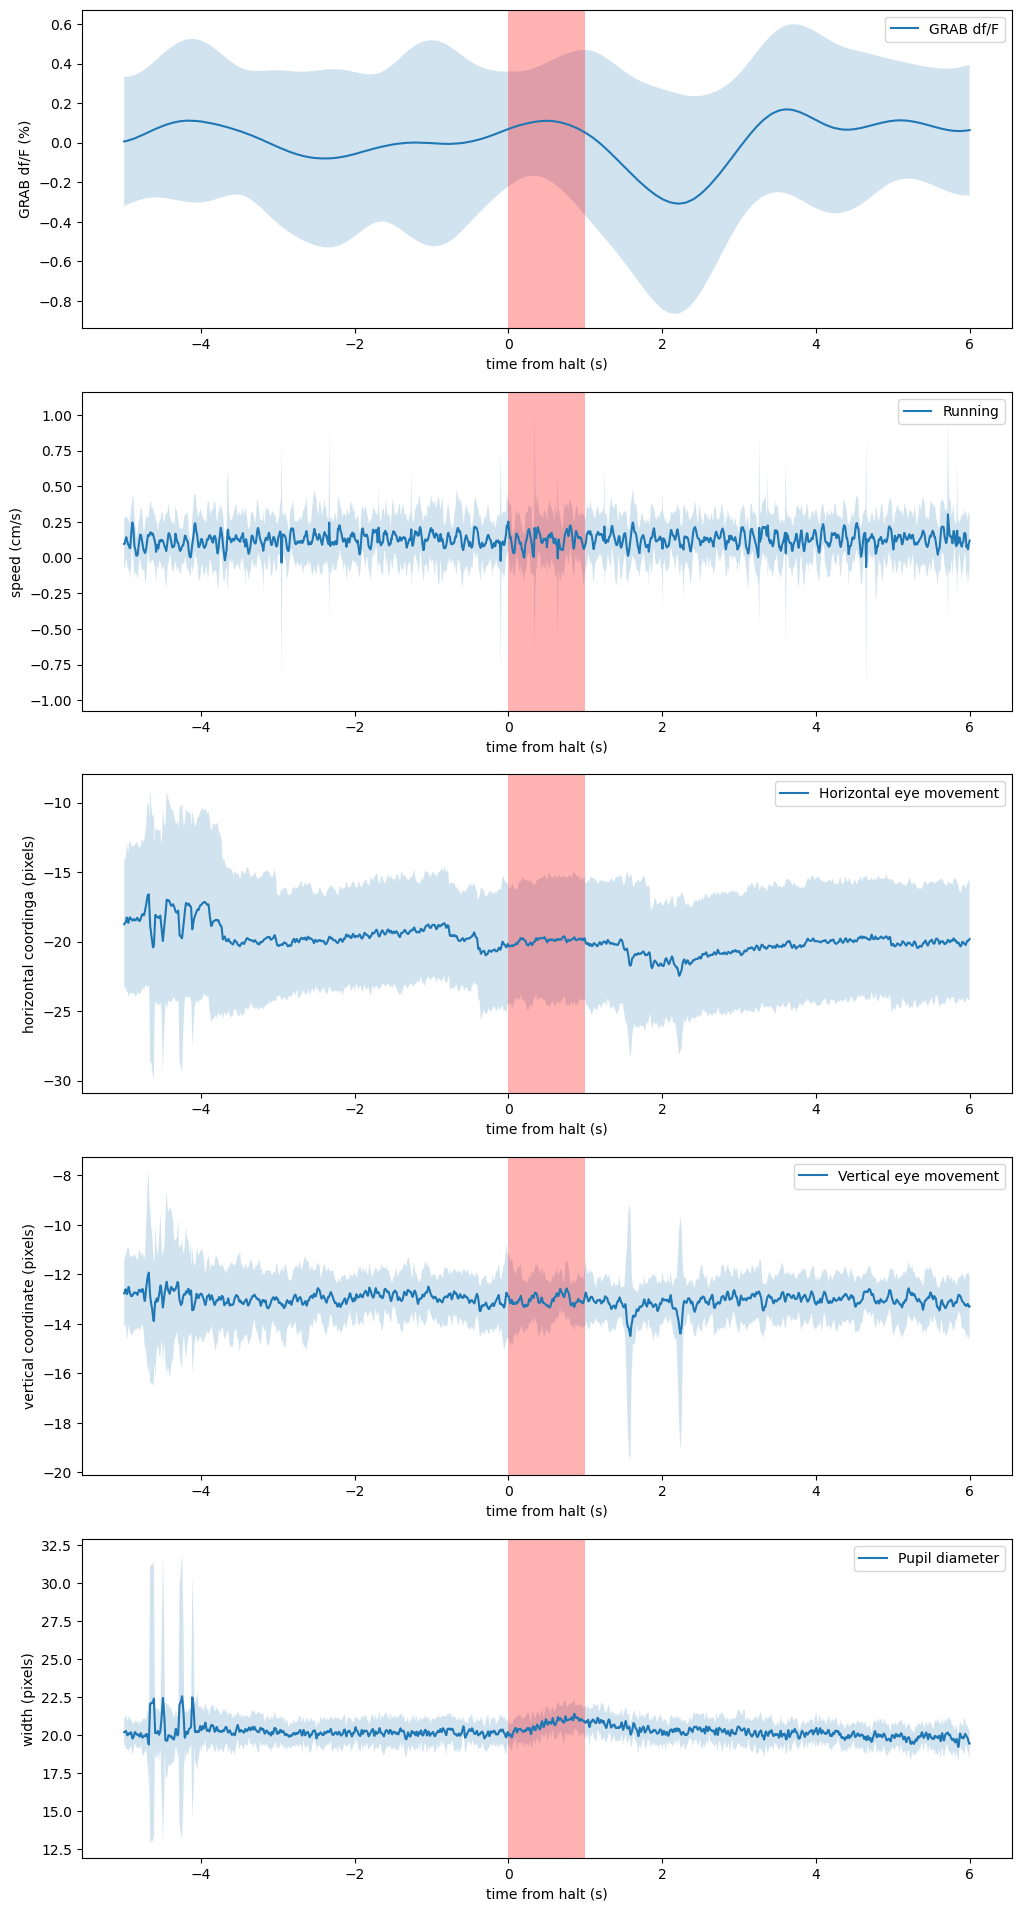

In [22]:
t = np.linspace(-before_event_period, during_event_period + after_event_period, average_running_chunk.shape[0])

# plt.figure(figsize=(12,6))

# plt.plot(photometry_t, average_photometry_chunk, label='GRAB df/F (%)', linewidth=3)
# plt.plot(running_t, average_running_chunk, c='black', label='running')
# plt.plot(running_t, average_ellipse_x_chunk, label='average_ellipse_x_chunk')
# plt.plot(running_t, average_ellipse_y_chunk, label='average_ellipse_y_chunk')
# plt.plot(running_t, average_ellipse_width_chunk, label='average_ellipse_width_chunk')
# # plt.axvline(0, c='r', alpha=0.5)

# plt.gca().add_patch(patches.Rectangle((0, plt.gca().get_ylim()[0]), 1, plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0], edgecolor='none',facecolor='red', alpha=0.3))

# plt.xlabel('time from halt (s)')
# plt.ylabel('relative change (%)')

# plt.legend()

# plt.show()



fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(12,4*6))

ax[0].plot(t, average_photometry_chunk, label='GRAB df/F')
ax[1].plot(t, average_running_chunk, label='Running')
ax[2].plot(t, average_ellipse_x_chunk, label='Horizontal eye movement')
ax[3].plot(t, average_ellipse_y_chunk, label='Vertical eye movement')
ax[4].plot(t, average_ellipse_width_chunk, label='Pupil diameter')

ax[0].fill_between(t, average_photometry_chunk-std_photometry_chunk, average_photometry_chunk+std_photometry_chunk, alpha=0.2)
ax[1].fill_between(t, average_running_chunk-std_running_chunk, average_running_chunk+std_running_chunk, alpha=0.2)
ax[2].fill_between(t, average_ellipse_x_chunk-std_ellipse_x_chunk, average_ellipse_x_chunk+std_ellipse_x_chunk, alpha=0.2)
ax[3].fill_between(t, average_ellipse_y_chunk-std_ellipse_y_chunk, average_ellipse_y_chunk+std_ellipse_y_chunk, alpha=0.2)
ax[4].fill_between(t, average_ellipse_width_chunk-std_ellipse_width_chunk, average_ellipse_width_chunk+std_ellipse_width_chunk, alpha=0.2)

for i in range(5):
    ax[i].add_patch(patches.Rectangle((0, ax[i].get_ylim()[0]), 1, ax[i].get_ylim()[1]-ax[i].get_ylim()[0], edgecolor='none',facecolor='red', alpha=0.3))
    ax[i].legend()
    ax[i].set_xlabel('time from halt (s)')

ax[0].set_ylabel('GRAB df/F (%)')
ax[1].set_ylabel('speed (cm/s)')
ax[2].set_ylabel('horizontal coordinga (pixels)')
ax[3].set_ylabel('vertical coordinate (pixels)')
ax[4].set_ylabel('width (pixels)')


plt.show()

In [25]:
streams['H1']['Cam1Event(33)']

,Cam1Event
Time,
1904-01-05 02:08:51.182336,1
1904-01-05 02:08:51.198976,1
1904-01-05 02:08:51.215648,1
1904-01-05 02:08:51.232320,1
1904-01-05 02:08:51.248992,1
...,...
1904-01-05 02:40:37.350592,1
1904-01-05 02:40:37.367264,1
1904-01-05 02:40:37.383936,1


In [30]:
pd.DataFrame(streams['H1']['OpticalTrackingRead1X(46)'])

,OpticalTrackingRead1X
Time,
1904-01-05 02:08:51.190240,0
1904-01-05 02:08:51.200256,0
1904-01-05 02:08:51.210240,0
1904-01-05 02:08:51.220256,0
1904-01-05 02:08:51.230240,0
...,...
1904-01-05 02:40:37.390240,0
1904-01-05 02:40:37.400256,0
1904-01-05 02:40:37.410240,0


In [34]:
pd.DataFrame(pd.DataFrame(streams['H1']['OpticalTrackingRead1X(46)'])).values

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int16)

In [48]:
pd.DataFrame({'OpticalTrackingTimestamps': pd.DataFrame(pd.DataFrame(streams['H1']['OpticalTrackingRead1X(46)'])).index, 'data': pd.DataFrame(pd.DataFrame(streams['H1']['OpticalTrackingRead1X(46)'])).values[:,0]})

,OpticalTrackingTimestamps,data
0,1904-01-05 02:08:51.190240,0
1,1904-01-05 02:08:51.200256,0
2,1904-01-05 02:08:51.210240,0
3,1904-01-05 02:08:51.220256,0
4,1904-01-05 02:08:51.230240,0
...,...,...
190620,1904-01-05 02:40:37.390240,0
190621,1904-01-05 02:40:37.400256,0
190622,1904-01-05 02:40:37.410240,0
190623,1904-01-05 02:40:37.420256,0


In [46]:
pd.DataFrame(pd.DataFrame(streams['H1']['OpticalTrackingRead1X(46)'])).values[:,0]

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [ ]:

pd.DataFrame(data={'OpticalTrackingTimestamps': pd.DataFrame(pd.DataFrame(streams['H1']['OpticalTrackingRead1X(46)'])).index.values, 'datapd.DataFrame(pd.DataFrame(streams['H1']['OpticalTrackingRead1X(46)'])).values})